In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
ecg_dataset=pd.read_csv("/content/ecg.csv")

In [ ]:
scaler=StandardScaler()  #Normalizes the data to have a mean of 0 and standard deviation of 1.
df=scaler.fit_transform(ecg_dataset)  #The scaled dataset values will be used as inputs for the model.

x_train, x_test=train_test_split(df,test_size=0.2) #Splits the dataset into X_train (80%) and X_test (20%) for training and testing.

In [ ]:
#X_train has 1000 samples, each with 20 features, then X_train.shape would be (1000, 20).

encoder=models.Sequential([  # creates a sequential model, meaning each layer's output is passed as the input to the next layer
    layers.Input(shape=(x_train.shape[1],)), #Defines the shape of the input, where x_train.shape[1] is number of features in the dataset) and ,  indicates it's a 1D shape.
    layers.Dense(32,activation='relu'), #Creates a dense (fully connected) layer with 32 neurons. acting as the first level of compression.
    layers.Dense(16,activation='relu'), # compressing the representation from 32 dimensions to 16.
    layers.Dense(8,activation='relu') #reduces the representation to 8 dimensions. This is the bottleneck layer,i.e  most compressed representation retains  most important features
])

In [ ]:
decoder=models.Sequential([
    layers.Input(shape=(8,)),  #The input shape for the decoder is set to (8,
    layers.Dense(16,activation='relu'),#Creates a dense (fully connected) layer with 16 neurons, expanding the dimensionality from 8 to 16.
    layers.Dense(32,activation='relu'), #Further expands the dimensionality from 16 to 32.
    layers.Dense(x_train.shape[1],activation='linear')# matches the dimensionality of the original input data. output values are not transformed by any non-linearity, allowing for a straightforward reconstruction of the input values.
])

In [ ]:
autoencoder=models.Sequential([
    encoder,
    decoder
])

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_train,x_train, epochs=10, batch_size=30, shuffle=True) #he input data , The target (output) is also X_train


# epochs: model will go through the entire training dataset 10 times
# batch_size:  During each epoch, the data will be divided into batches of 32 samples.
#shuffle: Shuffles the training data before each epoch

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8811
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3846
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2455
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2103
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2014
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1831
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1875
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1611
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1563
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1551


In [ ]:
#Detect anomalies

y_pred=autoencoder.predict(x_test)  #The output of the prediction, where each element is the reconstructed version of the corresponding input in X_test.
mse=np.mean(np.power(x_test-y_pred,2),1)
# difference between each original input (X_test) and its reconstructed version and Squares each element in the difference, resulting in a single MSE value per sample.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
threshold=np.percentile(mse,95)  #threshold value for mse, 95 indicates that we want to find a value such that 95% of the MSE values are below it, and only 5% are above it.
anomalies=mse > threshold
num_anomalies=np.sum(anomalies)

print("Number of Anomalies" ,num_anomalies)

Number of Anomalies 50


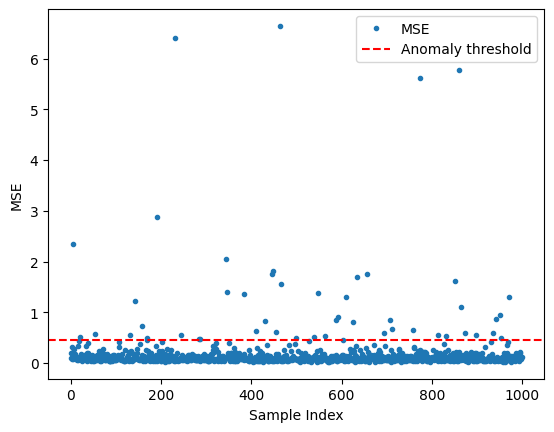

In [ ]:
# plot of mse vs anomalies threshold

plt.plot(mse,marker='o',linestyle='',markersize=3,label="MSE")
plt.axhline(threshold, linestyle='--', color='r',label="Anomaly threshold")
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

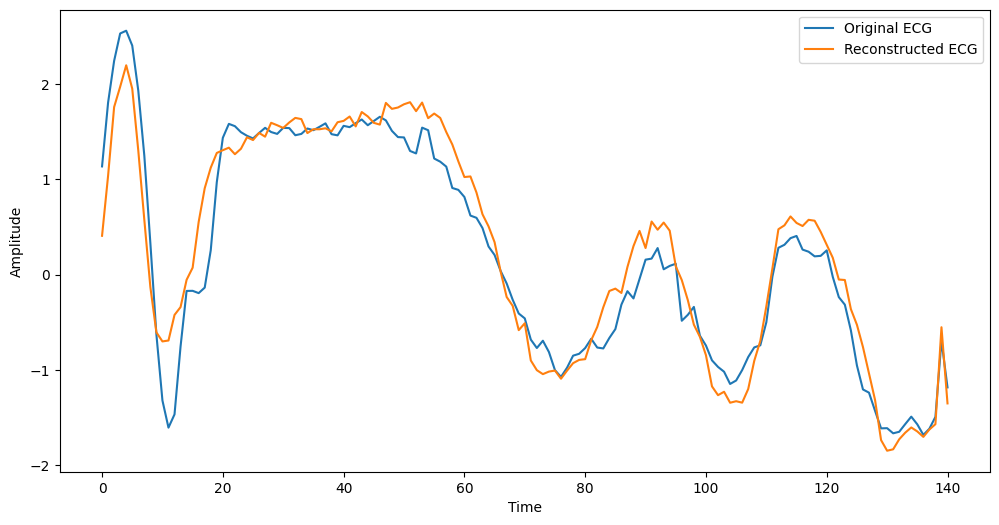

In [ ]:
#Original vs Reconstructed for normal data
plt.figure(figsize=(12,6))
plt.plot(x_test[0],label='Original ECG') #This accesses the first element (or sample) in the X_test dataset
plt.plot(y_pred[0],label='Reconstructed ECG')  #This accesses the first element in y_pred, which is the model’s reconstruction
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

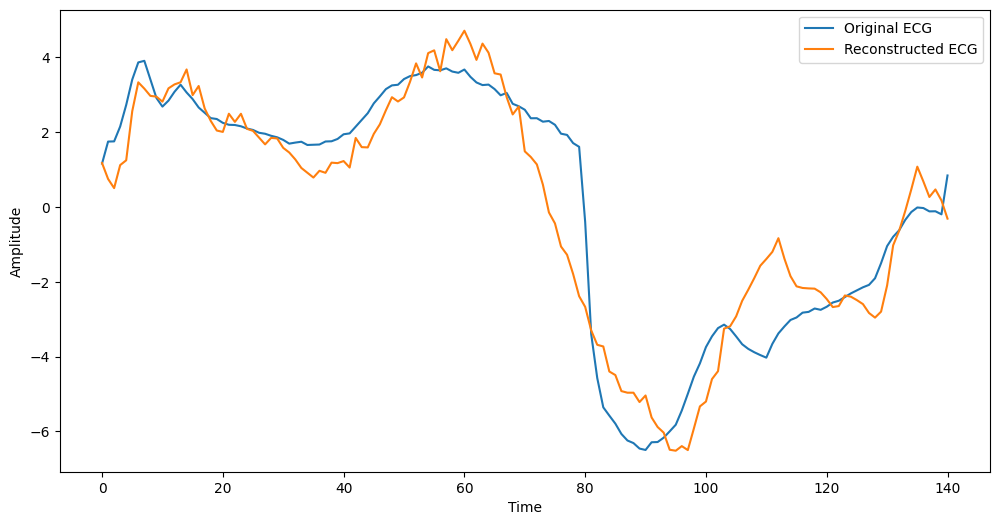

In [ ]:
anomalies_index=[index for index, anamoly in enumerate(anomalies) if anamoly]  #This condition filters the results. Only indices where anomaly is True are included in the new list.
n=4
anomaly_index=anomalies_index[n]
#anomalies_index is presumably a list containing the indices of data points identified as anomalies.
#By setting anomaly_index = anomalies_index[n], you are retrieving a specific anomaly's index—here, the fifth anomaly's index

plt.figure(figsize=(12,6))
plt.plot(x_test[anomaly_index],label='Original ECG')
plt.plot(y_pred[anomaly_index],label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show


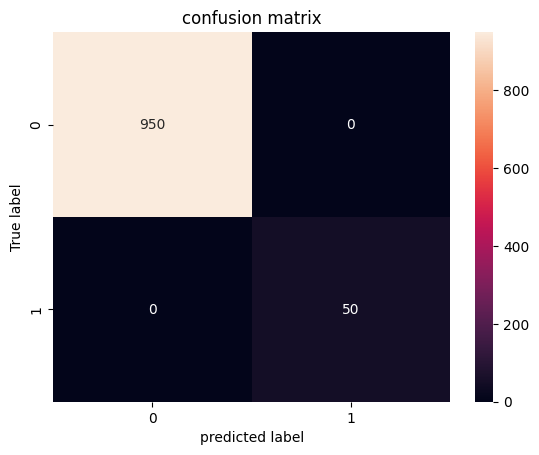

In [ ]:
sns.heatmap(confusion_matrix(anomalies, anomalies), annot=True, fmt='d')
plt.xlabel("predicted label")
plt.ylabel('True label')
plt.title('confusion matrix')
plt.show()
